# Figure 2: Drawing a phase diagram of immune strategies

This notebook contains the data analysis and visualization code needed to reproduce Figure 2. The figure explores optimal immune strategies as a function of the characteristic time and frequency of pathogens.

Prerequisite: produce numerical data

To generate the data needed for the following plot type

    make run

followed by

    make agg
    
This will generate three data files `phases.npz`, `pienvcut.npz` and `tauenvcut.npz` which contain respectively numerical results about the position of various phase boundaries, optimal parameters along a cut for fixed $\pi_{\rm env}$, and optimal parameters along a cut for fixed $\tau_{\rm env}$.

Import a number of packages that we will need in the following.

In [1]:
import sys
sys.path.append('../lib/')
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm, lines, transforms, gridspec, ticker
%matplotlib inline
import palettable
import shapely.geometry
import shapely.ops
import plotting
import evolimmune
import analysis
%load_ext autoreload
%autoreload 2
plt.style.use(['paper'])
eps = 1e-8

use czrecursion, cztogrowthrate
use cstepmarkov


Read in data about the position of phase boundaries.

In [2]:
df = analysis.loadnpz('data/phases.npz')

The following gives a summary of the data we just have read in. The columns with a single unique entries correspond to parameters set to a fixed value throughout the different optimizations.

In [3]:
analysis.intelligent_describe(df, nunique=10)

-----------------------------------------------------
values of columns with no more than 10 unique entries

boundary: ac; ap; cm; io; mi; pc; pi; pm; po
boundtol: 0.005
cup: 0.1*pup+pup**2
deltainit: 0.02
deltatol: 0.0005
lambda_: 3.0
logfeps: -9.0
mus: 1.0-2.0*epsilon/(1.0+epsilon), 1.0+0.8*epsilon
nburnin: 10000.0
niter: 1000000.0
qboundtol: 0.0005
xtol: 0.025
xtolbound: 0.01
-----------------------------------------------------
summary statistics of other columns

             aenv    pienvbnd
count  126.000000  126.000000
mean     0.499338    0.537614
std      0.355532    0.291394
min      0.000015   -0.025946
25%      0.133078    0.354840
50%      0.523847    0.582708
75%      0.855588    0.759486
max      0.951229    0.999274
-----------------------------------------------------


Deduce phases from boundaries between strategies

In [4]:
polygons = evolimmune.polygons_from_boundaries(df, yconv=evolimmune.to_tau)
phases = evolimmune.phases_from_polygons(polygons)
complete = polygons['complete']
c = phases['c']
a = phases['a']
pa = phases['p']
one = phases['o']
i = phases['i']
mix = phases['m']
qpos = shapely.ops.cascaded_union([c, mix, i])
strategies = [a, pa, one, i, mix, c]
strategies_s = ['a', 'p', 'o', 'i', 'm', 'c']
strategies_s_long = [r'adaptive', 'proto-\nadaptive', r'innate', 'innate\nbet\nhedging', r'mixed', r'CRISPR-like']

Define some common plotting parameters

In [5]:
commontextkwargs = dict(ha='center', va='center')
phaselabelkwargs = dict(fontsize='large')
phaselabelkwargs.update(commontextkwargs)
ymargin = 0.05
ymin, ymax = evolimmune.to_tau(df.aenv.min()), evolimmune.to_tau(df.aenv.max())
pad = 0.25
black = matplotlib.rcParams['text.color']
grey = 'grey'
colors = np.asarray(palettable.colorbrewer.qualitative.Set3_6.mpl_colors)[[4, 0, 2, 3, 5, 1]]
linecolors = dict(zip(('pup', 'p', 'cconstitutive', 'q', 'tau', 'tau1'), palettable.colorbrewer.qualitative.Dark2_6.mpl_colors))

Define helper functions for plotting and labelling phases

In [6]:
def plot_phases(ax, ylimmax, patchkwargs=dict()):
    for i, s in enumerate(strategies):
        try:
            ax.add_patch(analysis.shapely_to_mpl(s, ec='None', fc=colors[i], **patchkwargs))
        except:
            pass
    ax.set_xlim(0, 1)
    ax.set_ylim(ymin, ymax)
    ax.set_yscale('log')
    plotting.despine(ax, spines='all')

sx = dict(a=0.18, p=0.54, o=0.87, i=0.87, m=0.65, c=0.35)
sy = dict(a=0.5, p=0.3, o=0.3, i=3.5, m=4.2, c=8.0)
def label_phases(ax, textkwargs):
    for i, s in enumerate(strategies):
        ax.text(sx[strategies_s[i]], sy[strategies_s[i]],
                plotting.latexboldmultiline(strategies_s_long[i]), **textkwargs)

Produce stand alone phase diagram (subfig A)

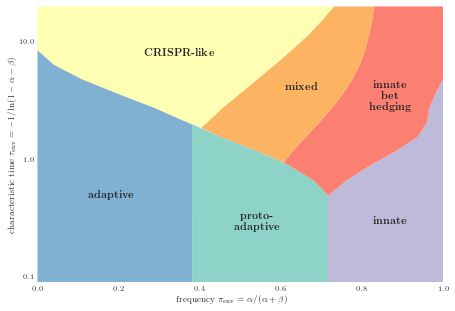

In [7]:
fig, ax = plt.subplots(ncols=1)
plot_phases(ax, ymax)
label_phases(ax, phaselabelkwargs)
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
l = ax.set_xlabel(r'frequency $\pi_{\rm env} = \alpha / (\alpha+\beta)$', verticalalignment='top')
l.set_position((l.get_position()[0]-0.02, l.get_position()[1]))
ax.set_ylabel(r'characteristic time $\tau_{\rm env} = -1/\ln(1-\alpha-\beta)$')
fig.tight_layout()

Define function for plotting phase diagram of strategic choices

In [8]:
def boundaryplots(axes, ylimmax=1.0, ylimmin=0.0):
    baseboundarykwargs = dict(lw=1.0)
    boundarykwargs = dict(color=black)
    boundarykwargs.update(baseboundarykwargs)
    patchkwargs = dict(fill=None, linewidth=0.0, alpha=1.0)
    analysis.plot_interior_boundary(axes[0], pa, ylimmax=ylimmax, ylimmin=ylimmin, **boundarykwargs)
    analysis.plot_interior_boundary(axes[0], a, ylimmax=ylimmax, ylimmin=ylimmin, **boundarykwargs)
    textkwargs = dict(color=linecolors['cconstitutive'], transform=axes[0].transAxes, **commontextkwargs)
    axes[0].text(0.53, 0.2, r'{\setlength{\jot}{-2pt}\begin{gather*}\bm{c_{\rm con.}}\\\bm{<}\\\bm{c_{\rm def.}}\end{gather*}}', **textkwargs)
    axes[0].text(0.2, 0.35, r'{\setlength{\jot}{-2pt}\begin{gather*}\bm{c_{\rm con.}}\\\bm{=}\\\bf{min}\end{gather*}}', **textkwargs)
    axes[0].text(0.67, 0.72, r'{\setlength{\jot}{-2pt}\begin{gather*}\bm{c_{\rm constitutive}}\\\bm{=}\\\bm{c_{\rm defense}}\end{gather*}}', **textkwargs)

    analysis.plot_interior_boundary(axes[1], qpos, ylimmax=ylimmax, ylimmin=ylimmin, **boundarykwargs)
    textkwargs = dict(fontsize='medium', color=linecolors['q'], transform=axes[1].transAxes, **commontextkwargs)
    axes[1].text(0.67, 0.82, r'$\bm{q > 0}$', **textkwargs)
    axes[1].text(0.37, 0.23, r'$\bm{q = 0}$', **textkwargs)
    
    analysis.plot_interior_boundary(axes[2], c, ylimmax=ylimmax, ylimmin=ylimmin, color=black, **baseboundarykwargs)
    analysis.plot_interior_boundary(axes[2], shapely.ops.cascaded_union((c, mix)), ylimmax=ylimmax, ylimmin=ylimmin, color=black, **baseboundarykwargs)
    text = axes[2].text(0.5, 0.2, r'$\bm{p > 0}$', fontsize='large', color=linecolors['p'], transform=axes[2].transAxes, **commontextkwargs)
    textbox = plotting.box_from_text(text)
    axes[2].add_patch(analysis.shapely_to_mpl(complete-c-shapely.geometry.box(*textbox.flatten()),
                                              hatch=r'////', ec=linecolors['p'], **patchkwargs))
    text = axes[2].text(0.34, 0.89, r'$\bm{p_{\rm uptake} > 0}$', color=linecolors['pup'], transform=axes[2].transAxes, **commontextkwargs)
    textbox = plotting.box_from_text(text)
    axes[2].add_patch(analysis.shapely_to_mpl(shapely.ops.cascaded_union((c, mix))-shapely.geometry.box(*textbox.flatten()),
                                              hatch=r'\\\\', ec=linecolors['pup'], **patchkwargs))

Produce stand alone phase diagram of strategic choices (subfig B)

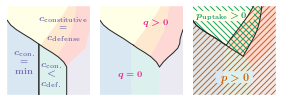

In [9]:
fig, axes = plt.subplots(ncols=3, figsize=(4.0, 1.5))
for ax in axes:
    plot_phases(ax, ymax, patchkwargs=dict(alpha=0.3))
    ax.set_xticks([])
    ax.set_yticks([])
boundaryplots(axes, ylimmax=ymax, ylimmin=ymin)
fig.tight_layout()

Define functions to plot optimal parameter values along cuts of constant $\pi_{\rm env}$ or $\tau_{\rm env}$.

In [10]:
def cutaxes(ax, label, color=black, labelkwargs=dict(), ymax=1.0, twin=False, yticklabels=None):
    plotting.despine(ax, spines='all')
    #yticks = [0.0, ymax/2, ymax]
    yticks = [0.0, ymax]
    ax.set_yticks(yticks)
    if yticklabels is None:
        yticklabels = ['%g' % yticks[0], '', '%g' % yticks[-1]]
    yticklabels = [yticklabels[0], yticklabels[-1]]
    ax.set_yticklabels(yticklabels)
    # add an invisible point to fool margin calculation
    ax.plot([0.0], [ymax], alpha=0.0)
    if twin:
        x = 1.05
    else:
        x = -.08
    ax.text(x, 0.5, label, color=color, transform=ax.transAxes, **ylabelkwargs)
    ax.margins(y=ymargin)
    for tl in ax.get_yticklabels():
        tl.set_color(color)
    return ax

def shade_according_to_phase(ax, phases, colors, x=None, y=None, transform=None, vspankwargs=dict()):
    if transform is None:
        transform = lambda val: val
    if x is not None:
        line = shapely.geometry.LineString(((x, 0), (x, 100)))
    if y is not None:
        line = shapely.geometry.LineString(((0, y), (1, y)))
    for i, phase in enumerate(phases):
        intersections = phase.boundary.intersection(line)
        if isinstance(intersections, shapely.geometry.MultiPoint):
            x0, y0 = intersections[0].xy
            x0, y0 = x0[0], y0[0]
            x1, y1 = intersections[1].xy
            x1, y1 = x1[0], y1[0]
            if x is not None:
                from_, to = y0, y1
            if y is not None:
                from_, to = x0, x1
            ax.axvspan(transform(from_), transform(to), color=colors[i], **vspankwargs)

Read in data for cuts

In [11]:
dftauenvcut = analysis.loadnpz('data/tauenvcut.npz')
dftauenvcut.p = pd.to_numeric(dftauenvcut.p, errors='coerce')
evolimmune.derived_quantities(dftauenvcut)
dftauenvcut_dict = dict((aenv, dfg) for aenv, dfg in dftauenvcut.groupby('aenv'))
aenvcuts = [key for key in dftauenvcut_dict][::-1]
dfpienvcut = analysis.loadnpz('data/pienvcut.npz')
dfpienvcut.p = pd.to_numeric(dfpienvcut.p, errors='coerce')
evolimmune.derived_quantities(dfpienvcut)

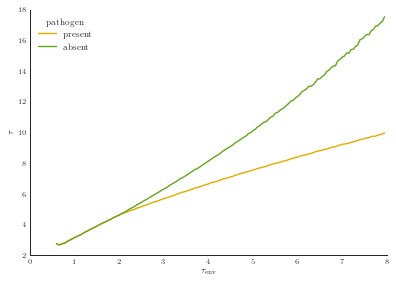

In [12]:
dfpienvcut = dfpienvcut[dfpienvcut.pi<0.9999]
axtau = plt.gca()
axtau.plot(dfpienvcut.tauenv, dfpienvcut.tau1, '-', c=linecolors['tau1'], label='present')
axtau.plot(dfpienvcut.tauenv, dfpienvcut.tau, '-', c=linecolors['tau'], label='absent')
axtau.legend(loc='best', title='pathogen')
plotting.despine(axtau)
axtau.set_xlabel(r'$\tau_{\rm env}$')
axtau.set_ylabel(r'$\tau$')

Put it all together and produce the final figure

/usr/local/lib/python2.7/dist-packages/matplotlib-1.5.0+335.g8928311-py2.7-linux-x86_64.egg/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


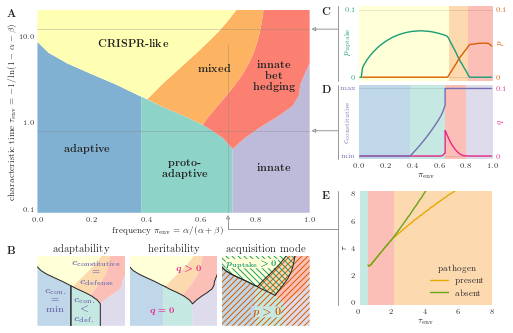

In [13]:
fig = plt.figure(figsize=(7.0, 4.5))
gsleft = gridspec.GridSpec(2, 3, height_ratios=[2.9, 1]) 

axphase = fig.add_subplot(gsleft[0, :])
plot_phases(axphase, ymax)
label_phases(axphase, phaselabelkwargs)
axphase.yaxis.set_major_formatter(ticker.ScalarFormatter())
l = axphase.set_xlabel(r'frequency $\pi_{\rm env} = \alpha / (\alpha+\beta)$', verticalalignment='top')
l.set_position((l.get_position()[0]-0.02, l.get_position()[1]))
axphase.set_ylabel(r'characteristic time $\tau_{\rm env} = -1/\ln(1-\alpha-\beta)$')

smallaxes = []
for counter in range(3):
    ax = fig.add_subplot(gsleft[1, counter])
    smallaxes.append(ax)
for ax in smallaxes:
    plot_phases(ax, ymax, patchkwargs=dict(alpha=0.5))
    ax.set_xticks([])
    ax.set_yticks([])
smallaxes[0].set_title('adaptability')
smallaxes[1].set_title('heritability')
smallaxes[2].set_title('acquisition mode')
# layout needs to be done before boundaryplots are drawn in order for cutouts to work
gsleft.tight_layout(fig, rect=(0, 0, 0.62, 1), h_pad=1.0, pad=pad, w_pad=0.5)
boundaryplots(smallaxes, ylimmax=ymax, ylimmin=ymin)

plotkwargs = dict()
vspankwargs = dict(alpha=0.5, ec='none')
ylabelkwargs = dict(rotation=90, ha='center', va='center', fontsize='medium')
switchingmax = 0.1

gsright = gridspec.GridSpec(2, 1) 

#### upper constant characteristic time cut panel ####
pienvcut = 0.7
dftauenvcut_sub = dftauenvcut_dict[aenvcuts[0]]
dftauenvcut_sub.sort_values(by='pienv', inplace=True)
axuppercut = fig.add_subplot(gsright[0])
shade_according_to_phase(axuppercut, strategies, colors, y=evolimmune.to_tau(aenvcuts[0]), vspankwargs=vspankwargs)
cutaxes(axuppercut, r'$p_{\rm uptake}$', color=linecolors['pup'], labelkwargs=ylabelkwargs,
        ymax=switchingmax, twin=False)
axuppercut.plot(dftauenvcut_sub.pienv, dftauenvcut_sub.pup, '-', c=linecolors['pup'], **plotkwargs)
axuppercut.set_xlabel('')
axuppercut.grid(axis='y')
plt.setp(axuppercut.get_xticklabels(), visible=False)
axuppercuttwin = cutaxes(axuppercut.twinx(), r'$p$', color=linecolors['p'], labelkwargs=ylabelkwargs, ymax=switchingmax, twin=True)
axuppercuttwin.plot(dftauenvcut_sub.pienv, dftauenvcut_sub.p, '-', c=linecolors['p'], **plotkwargs)

#### lower constant characteristic time cut panel ####
dftauenvcut_sub2 = dftauenvcut_dict[aenvcuts[1]]
dftauenvcut_sub2.sort_values(by='pienv', inplace=True)
axlowercut = fig.add_subplot(gsright[1], sharex=axuppercut)
cutaxes(axlowercut, r'$c_{\rm constitutive}$', color=linecolors['cconstitutive'], labelkwargs=ylabelkwargs,
        ymax=1.0, twin=False, yticklabels=['min', '', 'max'])
x, y = plotting.jumpify(dftauenvcut_sub2.pienv, dftauenvcut_sub2.cconstitutive, threshold=0.2)
axlowercut.plot(x, y, '-', c=linecolors['cconstitutive'], **plotkwargs)
axlowercut.set_xlabel(r'$\pi_{\rm env}$')
axlowercut.margins(y=ymargin)
axlowercuttwin = cutaxes(axlowercut.twinx(), r'$q$', color=linecolors['q'], labelkwargs=ylabelkwargs, ymax=switchingmax, twin=True)
shade_according_to_phase(axlowercuttwin, strategies, colors, y=evolimmune.to_tau(aenvcuts[1]), vspankwargs=vspankwargs)
axlowercuttwin.grid(axis='y')
x, y = plotting.jumpify(dftauenvcut_sub2.pienv, dftauenvcut_sub2.q, threshold=0.02)
axlowercuttwin.plot(x, y, '-', c=linecolors['q'], **plotkwargs)
# cconstitutive line on top of q line
axlowercut.set_zorder(axlowercuttwin.get_zorder()+1)
axlowercut.patch.set_visible(False)

#### frequency cut panel ####
dfpienvcut.sort_values(by='tauenv', inplace=True)
dfpienvcut = dfpienvcut[dfpienvcut.pi<0.9999]
gstau = gridspec.GridSpec(1, 1) 
axtau = fig.add_subplot(gstau[0])
axtau.plot(dfpienvcut.tauenv, dfpienvcut.tau1, '-', c=linecolors['tau1'], label='present')
axtau.plot(dfpienvcut.tauenv, dfpienvcut.tau, '-', c=linecolors['tau'], label='absent')
lims = [0, 8]
axtau.set_xlim(*lims)
w = (lims[1]-lims[0])*0.5
axtau.set_ylim(lims[0]-ymargin*w, lims[1]+ymargin*w)
axtau.set_xlabel(r'$\tau_{\rm env}$')
axtau.set_ylabel(r'$\tau$')
axtau.legend(loc='best', title='pathogen')
axtau.locator_params(nbins=6)
shade_according_to_phase(axtau, strategies, colors, x=pienvcut, vspankwargs=vspankwargs)
plotting.despine(axtau, spines='all')

#### make link to cuts ####
# plot lines corresponding to plots on the right
vlinekwargs=dict(color=grey, alpha=0.4, lw=0.8)
axphase.vlines([pienvcut], [0], [lims[1]], **vlinekwargs)
for aenv in aenvcuts:
    axphase.axhline(evolimmune.to_tau(aenv), **vlinekwargs)
offset = -.15
arrowprops = dict(edgecolor=grey, facecolor='w', arrowstyle='-|>',
         mutation_scale=8, shrinkA=0, clip_on=False)
transformB = transforms.blended_transform_factory(axlowercut.transAxes, axphase.transData)
axphase.annotate("", xy=(1.0, evolimmune.to_tau(aenvcuts[0])), xycoords=('axes fraction', 'data'),
     xytext=(offset, evolimmune.to_tau(aenvcuts[0])), textcoords=transformB,
     arrowprops=arrowprops)
transformB = transforms.blended_transform_factory(axuppercut.transAxes, axphase.transData)
axphase.annotate("", xy=(1.0, evolimmune.to_tau(aenvcuts[1])), xycoords=('axes fraction', 'data'),
     xytext=(-0.15, evolimmune.to_tau(aenvcuts[1])), textcoords=transformB,
     arrowprops=arrowprops)
transformB = transforms.blended_transform_factory(axtau.transAxes, axphase.transAxes)
axphase.annotate("", xy=(pienvcut, 0.0), xycoords=('data', 'axes fraction'),
     xytext=(-0.15, -0.08), textcoords=transformB,
     arrowprops=dict(connectionstyle='angle,angleA=180,angleB=-90,rad=0', **arrowprops))
for ax in [axlowercut, axuppercut, axtau]:
    line = lines.Line2D([offset, offset], [0.0, 1.0], color=grey, transform=ax.transAxes,
                        linewidth=matplotlib.rcParams['patch.linewidth'], clip_on=False)
    ax.add_line(line)

#### overall layout ####
gsright.tight_layout(fig, rect=(0.66, 0.45, 1.0, 1), h_pad=0.5, pad=pad)
gstau.tight_layout(fig, rect=(0.66, 0.0, 0.975, 0.43), pad=pad)
subfiglabelkwargs = dict(fontsize='large', verticalalignment='top', horizontalalignment='left')
axphase.text(0.005, 1.0, r'\textbf{A}',
         transform=transforms.blended_transform_factory(fig.transFigure, axphase.transAxes),
         **subfiglabelkwargs)
smallaxes[0].text(0.005, 1.15, r'\textbf{B}',
         transform=transforms.blended_transform_factory(fig.transFigure, smallaxes[0].transAxes),
         **subfiglabelkwargs)#
axuppercut.text(0.63, 1.0, r'\textbf{C}',
         transform=transforms.blended_transform_factory(fig.transFigure, axuppercut.transAxes),
         **subfiglabelkwargs)
axuppercut.text(0.63, 1.0, r'\textbf{D}',
         transform=transforms.blended_transform_factory(fig.transFigure, axlowercut.transAxes),
         **subfiglabelkwargs)
axtau.text(0.63, 1.0, r'\textbf{E}',
         transform=transforms.blended_transform_factory(fig.transFigure, axtau.transAxes),
         **subfiglabelkwargs)

fig.savefig('figure2.pdf')

**Optimal immune strategies as a function of the  frequency and characteristic time of pathogens.**
**(A)** Distinct optimal immune strategies emerge for different statistics of appearance of the pathogens. Each phase is characterized by the value of parameters indicated in panel B and named after a known immune system that has similar characteristics (the name 'adaptive' is after the vertebrate immune system).
**(B)** The different phases of immunity are defined by the values of parameters along three main axes: adaptability (constitutive cost $c_{\rm constitutive}$), heritability ($1-q$) and mode of acquisition ($p$ and $p_{\rm uptake}$). 
**(C)** and **(D)** Optimal parameters as a function of $\pi_{\rm env}$ for $\tau_{\rm env} = 12$ (C) and  $\tau_{\rm env} = 0.8$ (D). For slowly varying environments (C), rare pathogens are best targeted by CRISPR-like uptake of protection, while frequent pathogens are best dealt with by spontaneous acquisition of protection, with a crossover in-between where both co-exist. For faster varying environments (D), the constitutive cost invested in the protection goes from negligible to maximal as the pathogen frequency increases. When it is maximal, the best strategy transitions from bet-hedging ($q>0$) to a full protection of the population ($q=0$).
**(E)** The correlation times of protection in absence of the pathogen, $\tau = -1/\ln(1 - p - q)$, and in its presence, $\tau = -1/\ln(1 - p - p_{\rm uptake} - q)$, are shown for $\pi_{\rm env} = 0.7$ as a function of $\tau_{\rm env}$. Both increase with the correlation time of the pathogen. In this figure, an infinite population size is assumed and the following parameters are used: $c_{\rm infection} = 3; \; c_{\rm constitutive} = \left(1.8 - c_{\rm defense}\right) / \left(c_{\rm defense} - 0.2\right); \; c_{\rm uptake}(p_{\rm uptake}) = 0.1\times p_{\rm uptake} + p_{\rm uptake}^2$ (see Fig. S2 for other choices).